#### Kernel Ridge and SVR implementation for Brain Age 

- Tutorial [sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py) and [elsewhere](https://labex.io/tutorials/ml-kernel-ridge-regression-71096)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm

from plotnine import *
from pyprojroot import here
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.utils import resample
from statsmodels.nonparametric.smoothers_lowess import lowess


## Using statsmodels

In [2]:
df = pd.read_csv(f"{here()}/data/processed/df_corrected_age_2024-10-21.csv")

##### LOESS, Locally estimated scatterplot smooothing
- Fits multiple regression models to localized subsets of the data (e.g., 10-12). chooses a target point, and then creates a span/neighborhood of points around it to perform regression
- weighted regression: points in the neighborhood are weighted according to their distance from the target point e.g, a point (e.g., 7) closer to 5 (target age), will have more weight than one that is farther away (e.g., 15)
- flexible: captures complex, non-linear relationships between variables

#### Boostrap to get standard errors

### Implementation with bootstrapping as in [stata](https://www.stata.com/manuals/rnpregresskernel.pdf)

## Both Forbow and BHRC

In [3]:
frb = pd.read_csv(f"{here()}/data/processed/2025-05-08_sobp_nitya.csv") #/data/processed/df_corrected_age_2024-10-21.csv"
bhrc = pd.read_csv(f"{here()}/data/processed/2024-12-18_bhrc_all_waves.csv")

In [4]:
frb.rename(columns={'anx': 'anxiety'}, inplace=True)
frb.replace({1.0: 'Yes', 0.0: 'No'}, inplace=True)
df1 = frb[['scan_id', 'chronological_age', 'bag_z_scored', 'group', 'sex', 'adhd', 'anxiety']]
df2 = bhrc[['scan_id', 'chronological_age', 'bag_z_scored', 'group', 'sex', 'adhd', 'anxiety']]

In [5]:
df = pd.concat([df1, df2])

In [6]:
df.shape

(2173, 7)

In [7]:
df.head()

,scan_id,chronological_age,bag_z_scored,group,sex,adhd,anxiety
0,Yes,18.088980,0.958020,FHR (SMI),Female,No,Yes
1,Yes,23.819302,-0.605061,FHR (SMI),Female,Yes,Yes
2,Yes,22.803559,-0.190891,FHR (SMI),Female,Yes,Yes
3,3,15.542779,-0.759675,FHR (SMI),Male,No,Yes
4,3,17.689254,-0.527161,FHR (SMI),Male,No,Yes


In [8]:
df.group.value_counts()

group
FHR (SMI)    1281
Ctrls         892
Name: count, dtype: int64

##  Associations of Familial Risk Group, ADHD and Anxiety with zBag

– June – PNC renewal request

### 1. FORBOW

In [9]:

def zbag_age_smoothed_group(df:pd.DataFrame, var):

    plt.figure(figsize=(10, 6))

    df = df.dropna(subset=[var])

    groups = df[var].unique()
    color_palette = plt.cm.tab10.colors  # Use a colormap with enough distinct colors
    colors = {group: color_palette[i % len(color_palette)] for i, group in enumerate(groups)}

    # Loop through each group to fit a LOESS model and plot
    for group in groups:
        group_data = df[df[var] == group]

        # LOESS Smoothing
        smoothed_data = lowess(group_data['bag_z_scored'], group_data['chronological_age'], frac=0.3)
        
        # Bootstrap for confidence intervals
        n_bootstraps = 500
        boot_means = np.zeros((n_bootstraps, len(smoothed_data)))
        
        for i in range(n_bootstraps):
            # Bootstrap sample
            sample = group_data.sample(frac=1, replace=True)
            smoothed_sample = lowess(sample['bag_z_scored'], sample['chronological_age'], frac=0.3)
            boot_means[i, :] = np.interp(smoothed_data[:, 0], smoothed_sample[:, 0], smoothed_sample[:, 1])
        
        boot_mean = boot_means.mean(axis=0)
        boot_std = boot_means.std(axis=0)

        # Scatter plot for the group
        plt.scatter(group_data['chronological_age'], group_data['bag_z_scored'], alpha=0.5, color=colors[group], label=f'{group}')
        
        # Plot the LOESS line for the group
        plt.plot(smoothed_data[:, 0], smoothed_data[:, 1], color=colors[group], linewidth=2)


        # Confidence intervals
        plt.fill_between(smoothed_data[:, 0],
                        boot_mean - 1.96 * boot_std,
                        boot_mean + 1.96 * boot_std,
                        color=colors[group], alpha=0.2)
        

    # Labels and title
    plt.xlabel("Chronological Age, years")
    plt.ylabel("zBAG")
    plt.title(f"{var.capitalize()}")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:

def zbag_age_smoothed_line_group(df:pd.DataFrame, var):

    plt.figure(figsize=(10, 6))

    df = df.dropna(subset=[var])

    groups = df[var].unique()
    #colors = {'FHR (SMI)': 'red', 'Ctrls': 'black'}
    #colors = {group: color for group, color in zip(groups, ['red', 'black'])}
    color_palette = plt.cm.tab10.colors  # Use a colormap with enough distinct colors
    colors = {group: color_palette[i % len(color_palette)] for i, group in enumerate(groups)}

    # Loop through each group to fit a LOESS model and plot
    for group in groups:
        group_data = df[df[var] == group]

        # LOESS Smoothing
        smoothed_data = lowess(group_data['bag_z_scored'], group_data['chronological_age'], frac=0.3)
        
        # Bootstrap for confidence intervals
        n_bootstraps = 500
        boot_means = np.zeros((n_bootstraps, len(smoothed_data)))
        
        for i in range(n_bootstraps):
            # Bootstrap sample
            sample = group_data.sample(frac=1, replace=True)
            smoothed_sample = lowess(sample['bag_z_scored'], sample['chronological_age'], frac=0.3)
            boot_means[i, :] = np.interp(smoothed_data[:, 0], smoothed_sample[:, 0], smoothed_sample[:, 1])
        
        boot_mean = boot_means.mean(axis=0)
        boot_std = boot_means.std(axis=0)

        # Scatter plot for the group
        #plt.scatter(group_data['chronological_age'], group_data['bag_z_scored'], alpha=0.5, color=colors[group], label=f'{group}')
        
        # Plot the LOESS line for the group
        plt.plot(smoothed_data[:, 0], smoothed_data[:, 1], color=colors[group], linewidth=2,  label=f'{group}')

        # Confidence intervals
        plt.fill_between(smoothed_data[:, 0],
                        boot_mean - 1.96 * boot_std,
                        boot_mean + 1.96 * boot_std,
                        color=colors[group], alpha=0.2)

    plt.ylim(-3, 6)

    # Labels and title
    plt.xlabel("Chronological Age, years")
    plt.ylabel("zBAG")
    plt.title(f"{var.capitalize()}")
    plt.legend()
    plt.grid()
    plt.show()

#### Sex

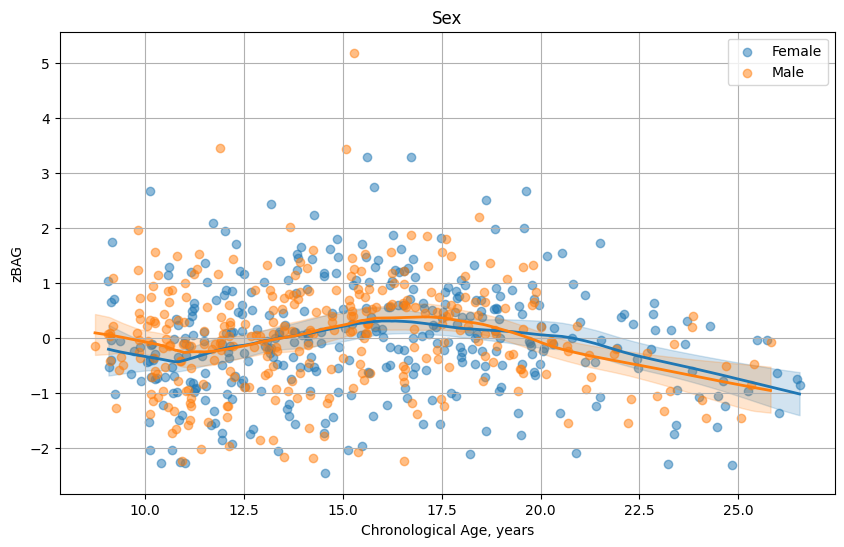

In [11]:
zbag_age_smoothed_group(frb, 'sex')

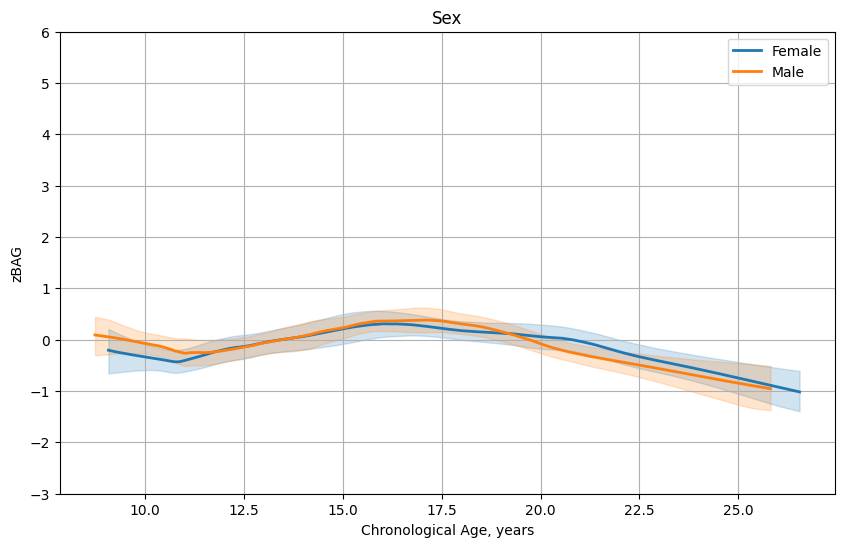

In [13]:
zbag_age_smoothed_line_group(frb, 'sex')

#### 1.1 Familial Risk Group

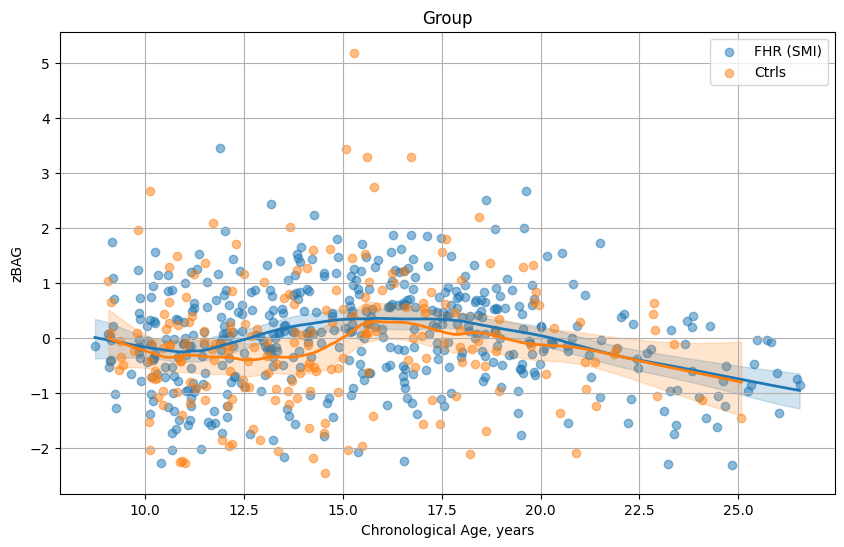

In [15]:
zbag_age_smoothed_group(frb, 'group')

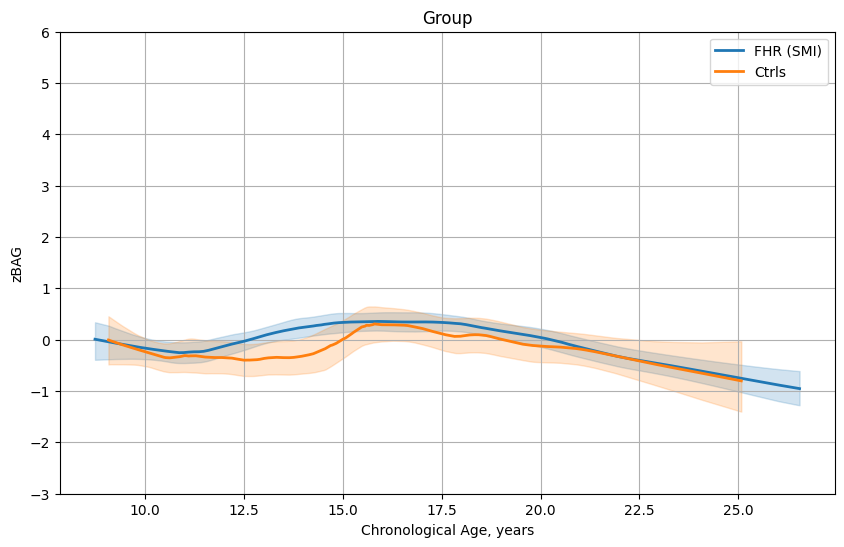

In [16]:
zbag_age_smoothed_line_group(frb, 'group')

#### 2.2 ADHD

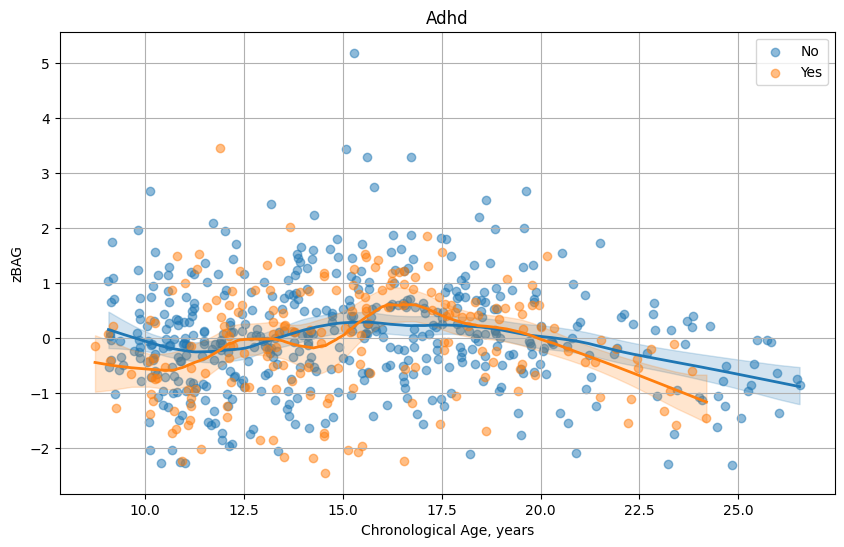

In [42]:
zbag_age_smoothed_group(frb, 'adhd')

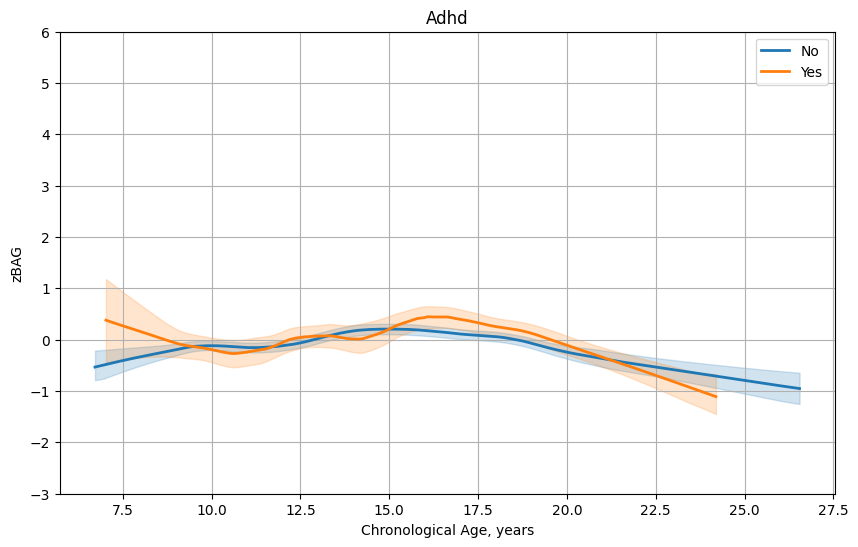

In [43]:
zbag_age_smoothed_line_group(df, 'adhd')

#### 3.3 Anxiety

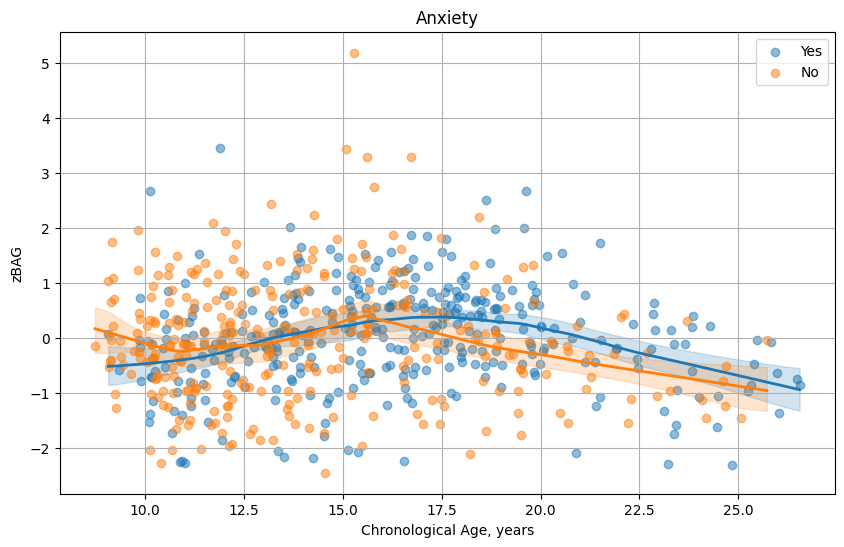

In [44]:
zbag_age_smoothed_group(frb, 'anxiety')

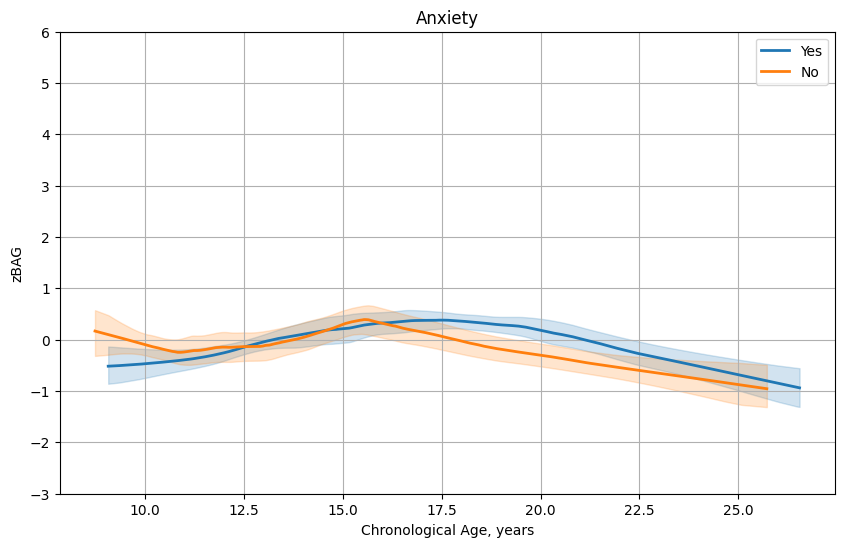

In [45]:
zbag_age_smoothed_line_group(frb, 'anxiety')

### 2. Brazilian High Risk Cohort

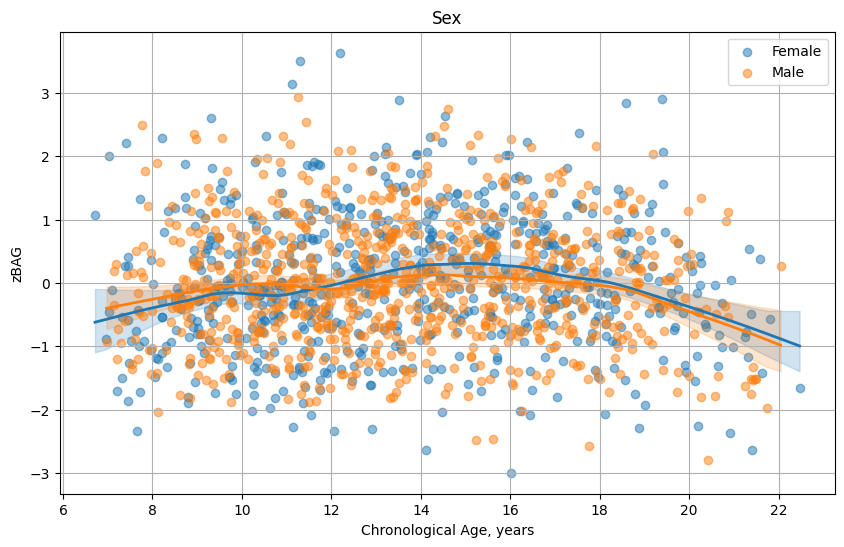

In [14]:
zbag_age_smoothed_group(bhrc, 'sex')

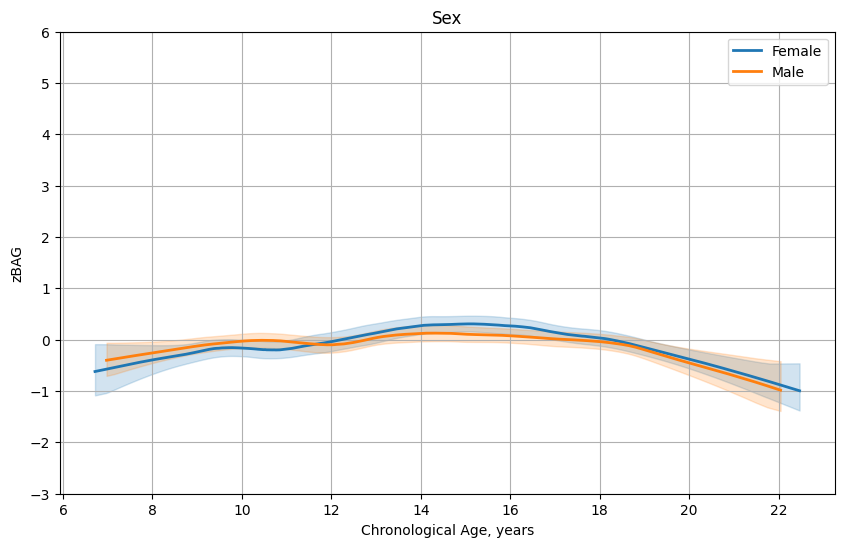

In [15]:
zbag_age_smoothed_line_group(bhrc, 'sex')

#### 2.1 Familial Risk Group

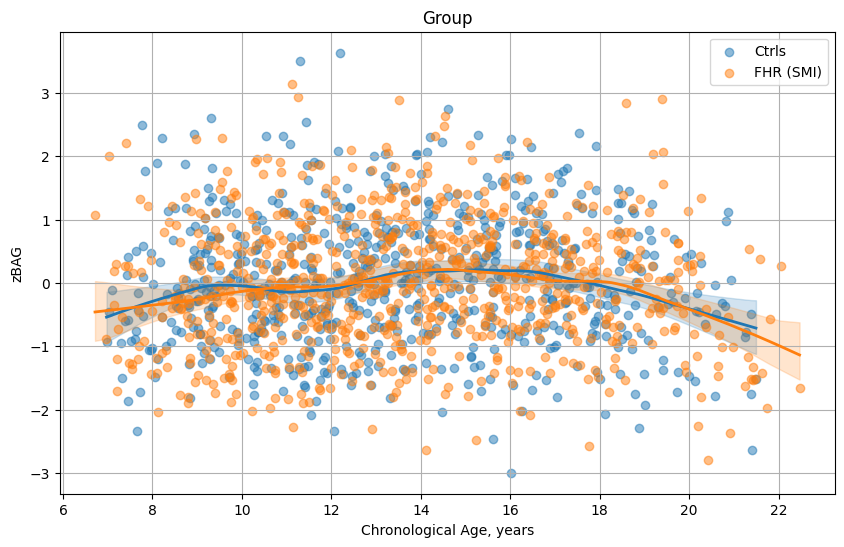

In [46]:
zbag_age_smoothed_group(bhrc, 'group')

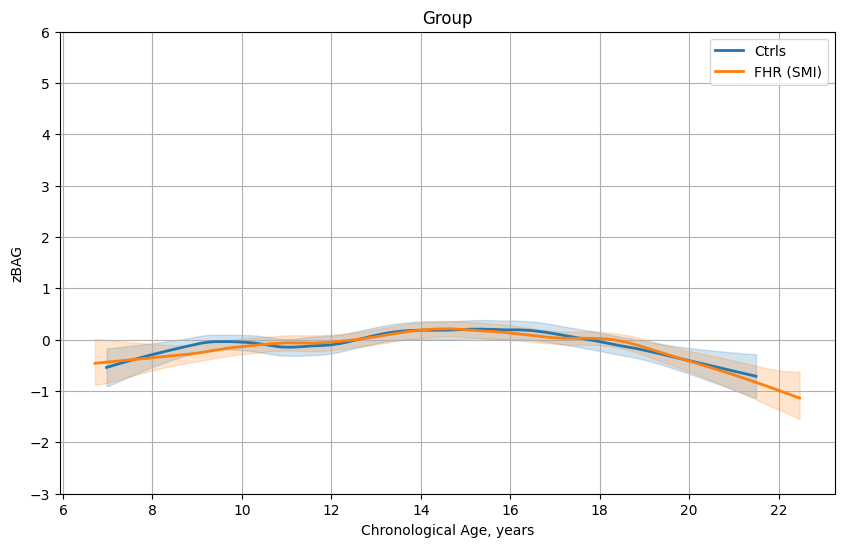

In [47]:
zbag_age_smoothed_line_group(bhrc, 'group')

#### 2.2 ADHD

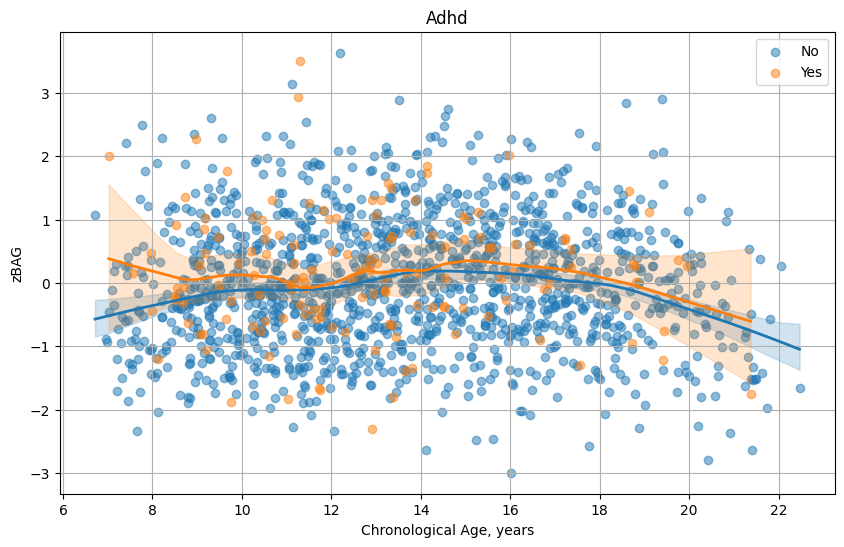

In [48]:
zbag_age_smoothed_group(bhrc, 'adhd')

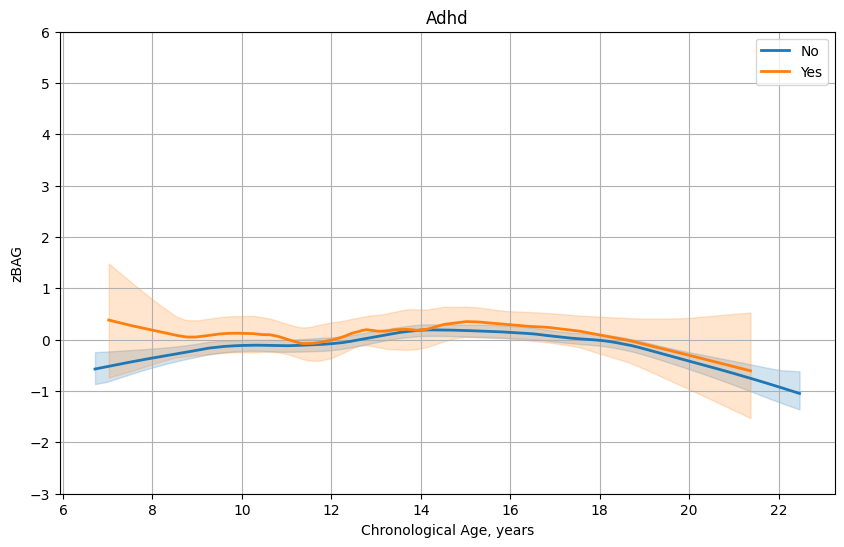

In [49]:
zbag_age_smoothed_line_group(bhrc, 'adhd')

#### 2.3 Anxiety

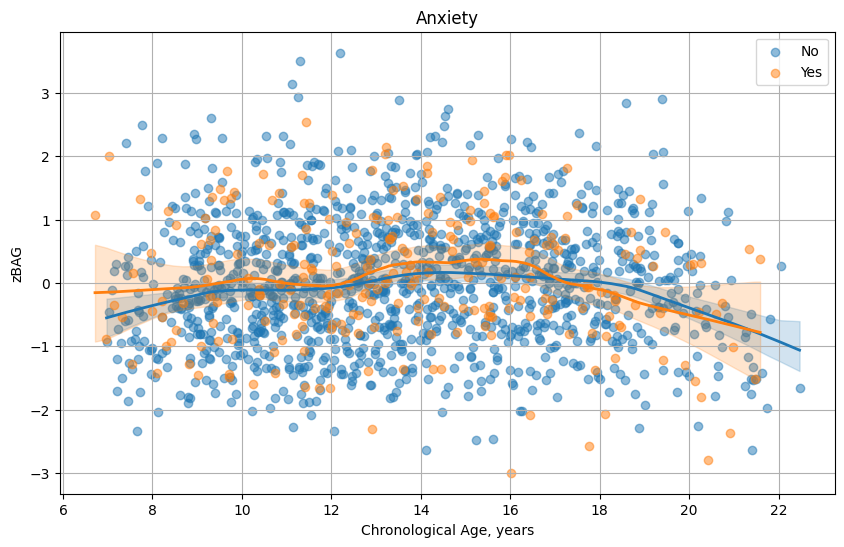

In [50]:
zbag_age_smoothed_group(bhrc, 'anxiety')

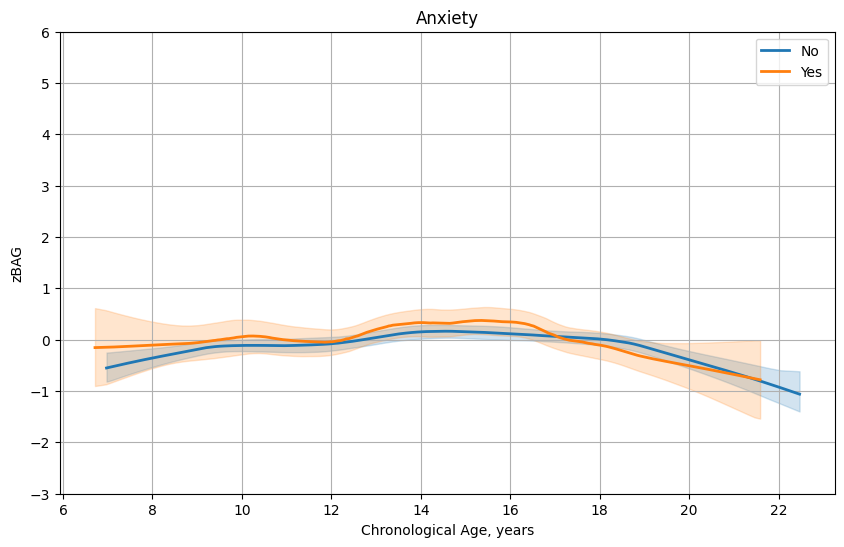

In [51]:
zbag_age_smoothed_line_group(bhrc, 'anxiety')

#### The END